Sequence prediction often involves forecasting the next value in a real valued sequence or outputting a class label for an input sequence.

This is often framed as a sequence of one input time step to one output time step (e.g. one-to-one) or multiple input time steps to one output time step (many-to-one) type sequence prediction problem.

There is a more challenging type of sequence prediction problem that takes a sequence as input and requires a sequence prediction as output. These are called sequence-to-sequence prediction problems, or seq2seq for short.

One modeling concern that makes these problems challenging is that the length of the input and output sequences may vary. Given that there are multiple input time steps and multiple output time steps, this form of problem is referred to as many-to-many type sequence prediction problem.

#### Architecture

The approach to seq2seq prediction problems that has proven very effective is called the Encoder Decoder LSTM. This architecture is comprised of two models: one for reading the input sequence and encoding it into a ﬁxed-length vector, and a second for decoding the ﬁxed-length vector and outputting the predicted sequence.

The use of the models in concert gives the architecture its name of Encoder-Decoder LSTM designed speciﬁcally for seq2seq problems.

The Encoder-Decoder LSTM was developed for natural language processing problems where it demonstrated state-of-the-art performance, speciﬁcally in the area of text translation called statistical machine translation.

The innovation of this architecture is the use of a **ﬁxed-sized internal representation** at the core of the model that input sequences are read to and output sequences are read from. For this reason, the method may be referred to as **sequence embedding**.

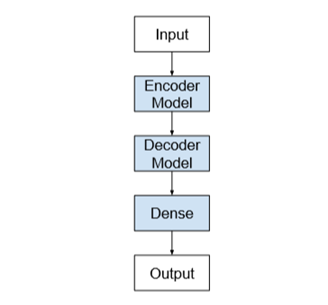

In [1]:
from IPython.display import Image
Image('C:/Users/Manoj/Desktop/Images/enc-dec lstm.png')

#### Applications

Below are the interesting applications of encoder-decoder LSTM architecture:

* **Machine Translation** e.g. English to French translation of phrases
* **Learning to Execute** e.g. calculate the outcome of small programs
* **Image Captioning** e.g. generating a text description for images
* **Conversational Modeling** e.g. generating answers to textual questions
* **Movement Classiﬁcation** e.g. generating a sequence of commands from a sequence of gestures

#### Implementation

We can think of the model as being comprised of two key parts: the encoder and the decoder. First, the input sequence is shown to the network one encoded character at a time.

We need an encoding level to learn the relationship between the steps in the input sequence and develop an internal representation of these relationships.

One or more LSTM layers can be used to implement the encoder model. The output of this model is a ﬁxed-size vector that represents the internal representation of the input sequence.

The number of memory cells in this layer deﬁnes the length of this ﬁxed-sized vector.

The decoder must transform the learned internal representation of the input sequence into the correct output sequence. One or more LSTM layers can also be used to implement the decoder model.

The same weights can be used to output each time step in the output sequence by wrapping the Dense layer in a **TimeDistributed** wrapper.

There’s a problem though. We must connect the encoder to the decoder, and they do not ﬁt. That is, the encoder will produce a 2-dimensional matrix of outputs, where the length is deﬁned by the number of memory cells in the layer.

The decoder is an LSTM layer that expects a 3D input of [samples, time steps, features] in order to produce a decoded sequence of some different length deﬁned by the problem.

We can solve this using a RepeatVector layer. This layer simply repeats the provided 2D input multiple times to create a 3D output.

The RepeatVector layer can be used like an adapter to ﬁt the encoder and decoder parts of the network together. We can conﬁgure the RepeatVector to repeat the ﬁxed length vector one time for each time step in the output sequence.

#### Addition Prediction Problem

The addition problem is a sequence-to-sequence, or seq2seq, prediction problem. It was used by Wojciech Zaremba and Ilya Sutskever in their 2014 paper exploring the capabilities of the Encoder-Decoder LSTM titled “Learning to Execute” where the architecture was demonstrated learning to calculate the output of small programs.

The problem is deﬁned as calculating the sum output of two input numbers. This is challenging as each digit and mathematical symbol is provided as a character and the expected output is also expected as characters. For example, the input 10+6 with the output 16 would be represented by the sequences:

* Input: [ ‘1’ , ‘0’ , ‘+’ , ‘6’] 
* Output: [ ‘1’ , ‘6’ ]

The model must learn not only the integer nature of the characters, but also the nature of the mathematical operation to perform. 

Also notice how the number of digits could vary in both the input and output sequences.

Technically this makes the addition prediction problem a sequence-to-sequence problem that requires a many-to-many model to address.

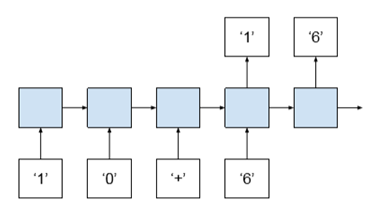

In [2]:
Image('C:/Users/Manoj/Desktop/Images/seq2seq.png')

Let's keep the problem simple with addition of two numbers, but we can see how this may be scaled to a variable number of terms and mathematical operations that could be given as input for the model to learn and generalize.

We will divide this whole task into the following steps:

1. Generate sum pairs
2. Integers to Padded Strings
3. Integer Encoded Sequences
4. One Hot Encoded Sequences
5. Sequence Generation Pipeline
6. Decode Sequences

The ﬁrst step is to generate sequences of random integers and their sum

In [45]:
from random import seed 
from random import randint
import numpy as np
# generate lists of random integers and their sum
def random_sum_pairs(n_examples, n_numbers, largest):
    X, y = list(), list()
    for i in range(n_examples):
        in_pattern = [randint(1,largest) for _ in range(n_numbers)]
        out_pattern = sum(in_pattern)
        X.append(in_pattern)
        y.append(out_pattern)
    return X, y

In [25]:
#test function
seed(1) 
n_samples = 1 
n_numbers = 2 
largest = 10 
# generate pairs 
X, y = random_sum_pairs(n_samples, n_numbers, largest)
print(X, y)

[[3, 10]] [13]


The next step is to convert the integers to strings. The input string will have the format ‘10+10’ and the output string will have the format ‘20’. Key to this function is the padding of numbers to ensure that each input and output sequence has the same number of characters.

A padding character should be different from the data so the model can learn to ignore them. In this case, we use the space character for padding(‘ ’) and pad the string on the left, keeping the information on the far right.

Padding requires us to know how long the longest sequence may be.

We can calculate this easily by taking the log10() of the largest integer we can generate and the ceiling of that number to get an idea of how many chars are needed for each number.

We add 1 to the largest number to ensure we expect 3 chars instead of 2 chars for the case of a round largest number, like 200 and take the ceiling of the result (e.g. ceil(log10(largest+1))). We then need to add the right number of plus symbols (e.g. n numbers-1).

max_length = n_numbers * ceil(log10(largest+1)) + n_numbers – 1

Let's make this concrete with a worked example where the total number of terms (n numbers) is 3 and the largest value (largest) is 10.

* max_length = 3 * ceil(log10(10+1))+3-1
* max_length = 3 * ceil(1.0413926851582251)+3-1
* max_length = 8

Intuitively, we would expect 2 spaces for each term (e.g. [‘1’,‘0’]) multiplied by 3 terms, or a maximum length of input sequences of 6 spaces with two more spaces for the addition symbols (e.g. [‘1’,‘0’,‘+’,‘1’,‘0’,‘+’,‘1’,‘0’]) making the largest possible sequence 8 characters in length. 

we can calculate the expected maximum output sequence length for the above example with the total number of terms (n numbers) is 3 and the largest value (largest) is 10.

* max_length = ceil(log10(n_numbers * (largest+1)))
* max_length = 2

Again, intuitively, we would expect the largest possible addition to be 10+10+10 or the value of 30. This would require a maximum length of 2.

In [21]:
from math import ceil, log10
# convert data to strings 
def to_string(X, y, n_numbers, largest):
    max_length = n_numbers * ceil(log10(largest+1)) + n_numbers - 1
    Xstr = list()
    for pattern in X:
        strp = '+'.join([str(n) for n in pattern])
        strp = ''.join(['' for _ in range(max_length-len(strp))]) + strp
        Xstr.append(strp)
    max_length = ceil(log10(n_numbers * (largest+1)))
    ystr = list()
    for pattern in y:
        strp = str(pattern)
        strp = ''.join(['' for _ in range(max_length-len(strp))]) + strp
        ystr.append(strp)
    return Xstr, ystr

In [24]:
#test function
seed(1) 
n_samples = 1 
n_numbers = 2 
largest = 10

# generate pairs 
X, y = random_sum_pairs(n_samples, n_numbers, largest) 
print(X, y)

# convert to strings 
X, y = to_string(X, y, n_numbers, largest) 
print(X, y)

[[3, 10]] [13]
['3+10'] ['13']


Next, we need to encode each character in the string as an integer value. We have to work with numbers in neural networks after all, not characters. Integer encoding transforms the problem into a classiﬁcation problem where the output sequence may be considered class outputs with 11 possible values each.

This just so happens to be integers with some ordinal relationship (the ﬁrst 10 class values). To perform this encoding, we must deﬁne the full alphabet of symbols that may appear in the string encoding, as follows:

alphabet = [ ‘0’ ,’1’ ,’2’ ,’3’ ,’4’ ,’5’ ,’6’ ,’7’ ,’8’ ,’9’ ,’+’ ,’ ’ ]

Integer encoding then becomes a simple process of building a lookup table of character-to integer offset and converting each char of each string, one by one. 

In [26]:
# integer encode strings 
def integer_encode(X, y, alphabet):
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    Xenc = list()
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    yenc = list()
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    return Xenc, yenc

In [29]:
seed(1) 
n_samples = 1 
n_numbers = 2 
largest = 10 
# generate pairs 
X, y = random_sum_pairs(n_samples, n_numbers, largest) 
print(X, y) 
# convert to strings 
X, y = to_string(X, y, n_numbers, largest) 
print(X, y) 
# integer encode 
alphabet = ['0','1','2','3','4','5','6','7','8','9','+',''] 
X, y = integer_encode(X, y, alphabet) 
print(X, y)

[[3, 10]] [13]
['3+10'] ['13']
[[3, 10, 1, 0]] [[1, 3]]


Next step is to binary encode the integer encoding sequences. This involves converting each integer to a binary vector with the same length as the alphabet and marking the speciﬁc integer with a 1.

In [33]:
# one hot encode 
def one_hot_encode(X, y, max_int):
    Xenc = list()
    for seq in X:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        Xenc.append(pattern)
    yenc = list()
    for seq in y:
        pattern = list()
        for index in seq:
            vector = [0 for _ in range(max_int)]
            vector[index] = 1
            pattern.append(vector)
        yenc.append(pattern)
    return Xenc, yenc

In [34]:
seed(1) 
n_samples = 1 
n_numbers = 2 
largest = 10 
# generate pairs 
X, y = random_sum_pairs(n_samples, n_numbers, largest) 
print(X, y) 
# convert to strings 
X, y = to_string(X, y, n_numbers, largest) 
print(X, y) 
# integer encode 
alphabet = ['0','1','2','3','4','5','6','7','8','9','+',''] 
X, y = integer_encode(X, y, alphabet) 
print(X, y)
# one hot encode 
X, y = one_hot_encode(X, y, len(alphabet)) 
print(X, y)

[[3, 10]] [13]
['3+10'] ['13']
[[3, 10, 1, 0]] [[1, 3]]
[[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]] [[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]]


##### Sequence Generation Pipeline

In [43]:
# generate an encoded dataset 
def generate_data(n_samples, n_numbers, largest, alphabet): 
    # generate pairs 
    X, y = random_sum_pairs(n_samples, n_numbers, largest) 
    # convert to strings 
    X, y = to_string(X, y, n_numbers, largest) 
    # integer encode 
    X, y = integer_encode(X, y, alphabet) 
    # one hot encode 
    X, y = one_hot_encode(X, y, len(alphabet)) 
    # return as NumPy arrays 
    X, y = np.array(X), np.array(y) 
    return X, y

Finally, we need to invert the encoding to convert the output vectors back into numbers so we can compare expected output integers to predicted integers.

In [36]:
# invert encoding 
def invert(seq, alphabet):
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    strings = list()
    for pattern in seq:
        string = int_to_char[argmax(pattern)]
        strings.append(string)
    return ''.join(strings)

#### Define and Compile the Model

The ﬁrst step is to deﬁne the speciﬁcations of the sequence prediction problem. We need to specify 3 parameters as input to the generate_data() function (above) for generating samples of input-output sequences:

* n_terms: The number of terms in the equation, (e.g. 2 for10+10)
* largest: The largest numerical value for each term (e.g. 10 for values between 1-10)
* alphabet: The symbols used to encode the input and output sequences (e.g. 0-9, + and '')

Let's configure the problem where each instance will be comprised of 3 terms with the maximum value of 10 per term. The alphabet remains ﬁxed regardless of conﬁguration with the values 0-9, ‘+’, and ‘ ’.

In [37]:
# number of math terms 
n_terms = 3 
# largest value for any single input digit 
largest = 10 
# scope of possible symbols for each input or output time step 
alphabet = [str(x) for x in range(10)] + ['+','']

Additionally, the network needs 3 more conﬁguration values deﬁned by the speciﬁcation of the addition problem:

* n_chars: The size of the alphabet for a single time step (e.g. 12 for 0-9, ‘+’ and '')
* n_in_seq_length: The number of time steps of encoded input sequences (e.g. 8 for ‘10+10+10’)
* n_out_seq_length: The number of time steps of an encoded output sequence (e.g. 2 for ‘30’)

In [39]:
# size of alphabet: (12 for 0-9, + and ) 
n_chars = len(alphabet)
# length of encoded input sequence (8 for 10+10+10) 
n_in_seq_length = n_terms * ceil(log10(largest+1)) + n_terms - 1
# length of encoded output sequence (2 for 30 )
n_out_seq_length = ceil(log10(n_terms * (largest+1)))

We can now define Encoder-Decoder LSTM. We will use a single LSTM layer for the encoder and another single layer for the decoder.

The encoder is deﬁned with 75 memory cells and the decoder with 50 memory cells. The asymmetry in layer sizes in the encoder and decoder seems like a natural organization given that input sequences are relatively longer than output sequences.

The output layer uses the categorical log loss for the 12 possible classes that may be predicted. The efficient Adam implementation of gradient descent is used and accuracy will be calculated during training and model evaluation.

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
# define encoder-decoder LSTM 
model = Sequential() 
model.add(LSTM(75, input_shape=(n_in_seq_length, n_chars)))
model.add(RepeatVector(n_out_seq_length))
model.add(LSTM(50, return_sequences=True)) 
model.add(TimeDistributed(Dense(n_chars, activation= 'softmax'))) 
model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['acc']) 
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                26400     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 2, 75)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 2, 50)             25200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 12)             612       
Total params: 52,212
Trainable params: 52,212
Non-trainable params: 0
_________________________________________________________________
None


#### Fit the Model

model is fitted on a single epoch of 75,000 randomly generated instances of input-output pairs. The number of sequences is a proxy for the number of training epochs.

In [50]:
# fit model 
X, y = generate_data(75000, n_terms, largest, alphabet) 
model.fit(X, y, epochs=1, batch_size=32)

ValueError: Error when checking input: expected lstm_3_input to have 3 dimensions, but got array with shape (75000, 1)

In [51]:
X.shape

(75000,)